In [1]:
# Setup the folder structure. It might already be there, and that's fine
from os import makedirs

makedirs("data/sentences", exist_ok=True)

Use the _magic_ [sh](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-sh) directive to run CLI commands.

In [2]:
%%sh
# We add -d to only output directories
tree . -d

.
└── data
    └── sentences

2 directories


In [3]:
# Download a dataset made of sentences found in moview reviews. The sentences need to be at least 3 seconds long when
# being read out loud. The sentences are packed in tarball gunzip archive as two files.
from urllib.request import urlretrieve

urlretrieve("http://www.cs.cornell.edu/people/pabo/movie-review-data/rotten_imdb.tar.gz",
            "data/sentences/sentences.tar.gz")

('data/sentences/sentences.tar.gz',
 <http.client.HTTPMessage at 0x7f06b0432110>)

In [4]:
%%sh
ls -al data/sentences/

total 568
drwxr-xr-x 3 docker docker     96 Dec  3 19:14 .
drwxr-xr-x 3 docker docker     96 Dec  3 19:14 ..
-rw-r--r-- 1 docker docker 519599 Dec  3 19:14 sentences.tar.gz


In [5]:
# Extract the files from the tarball archive.
# We use the "with" syntax so that the file handler is closed automatically afterwards.
import tarfile

with tarfile.open("data/sentences/sentences.tar.gz") as tar:
    tar.extractall("data/sentences")

In [6]:
%%sh
# We can now see two files that have the extension 5000
# The 5000 represents how many samples are in each of the files.
ls -al data/sentences/

total 1848
drwxr-xr-x 6 docker docker    192 Dec  3 19:14 .
drwxr-xr-x 3 docker docker     96 Dec  3 19:14 ..
-rw------- 1 docker docker 669456 Jun 22  2004 plot.tok.gt9.5000
-rw------- 1 docker docker 630790 Jun 22  2004 quote.tok.gt9.5000
-rw-r--r-- 1 docker docker 519599 Dec  3 19:14 sentences.tar.gz
-rw------- 1 docker docker   2309 Jun 21  2004 subjdata.README.1.0


In [7]:
%%sh
# Sentences are one per line. here are the first 3
head -n3 data/sentences/quote.tok.gt9.5000

smart and alert , thirteen conversations about one thing is a small gem . 
color , musical bounce and warm seas lapping on island shores . and just enough science to send you home thinking . 
it is not a mass-market entertainment but an uncompromising attempt by one artist to think about another . 


In [8]:
# Read the sentences from both files and create a list of sentences.
# The sentences are written using a specific encoding which must be used again when reading the files.

sentences = []
with open("data/sentences/plot.tok.gt9.5000", "r", encoding = "ISO-8859-1") as fp:
    sentences.extend(fp.read().split("\n")[0:5000])
with open("data/sentences/quote.tok.gt9.5000", "r", encoding = "ISO-8859-1") as fp:
    sentences.extend(fp.read().split("\n")[0:5000])

In [9]:
# First few sentences
sentences[:3]

['the movie begins in the past where a young boy named sam attempts to save celebi from a hunter . ',
 'emerging from the human psyche and showing characteristics of abstract expressionism , minimalism and russian constructivism , graffiti removal has secured its place in the history of modern art while being created by artists who are unconscious of their artistic achievements . ',
 "spurning her mother's insistence that she get on with her life , mary is thrown out of the house , rejected by joe , and expelled from school as she grows larger with child . "]

In [10]:
makedirs("data/mp3", exist_ok=True)

In [14]:
import boto3

# This is a client object that allows us to communicate with the AWS service
# We need a instance of the Polly client
session = boto3.session.Session()
client = session.client("polly", region_name="us-east-1")

In [15]:
# Define a list with the voices in AWS Polly
voices = ["Ivy", "Joanna", "Joey", "Justin", "Kendra", "Kimberly", "Matthew", "Salli"]

In [16]:
# closing is a convenience stream utility so that we
# don't have to close the stream manually.
# io allows us to work with stream of data coming from Polly.
import random
from contextlib import closing
import io

# We need an id in the form of a counter for the sentences sequence,
# and the sentence itself
def process_input(i, sentence):
    # We randomly pick a voice to say the sentence out loud.
    voice = random.choice(voices)

    # The path to the mp3 we are about to download and write to disk
    # The voice that was used is part of the file name. We can use it for
    # labeling our training data later one
    file_mask = "data/mp3/sample-{:05}-{}.mp3".format(i, voice)

    # Ask Polly to do its magic
    response = client.synthesize_speech(
        OutputFormat="mp3",
        Text=sentence,
        TextType="text",
        VoiceId=voice
    )
    # Get the bytes stream containing the mp3
    with closing(response["AudioStream"]) as stream:
        # Write the stream to a bytes buffer in memory
        with io.BytesIO() as buffer:
            # If we fail, for whatever reason (Eg: AWS is throttling us), we skip the file
            try:
                buffer.write(stream.read())
                buffer.seek(0)
                # Finally write the mp3 to disk
                with open(file_mask, "wb") as out:
                    out.write(buffer.read())
            except _:
                pass

In [17]:
# This will take some time

# To move things faster we'll do "multi threading"
from multiprocessing.pool import ThreadPool

# We launch a maximum of 10 functions at a time for each sentence in the set
# To make the rest of tutorial reasonable fast, we'll use just 2000 sentences instead of the 10.000 we have available.
# This will, of course, have a negative impact on the final model.
with ThreadPool(processes=10) as pool:
    pool.starmap(process_input, enumerate(sentences[:2000]))

In [18]:
%%sh
# Show a few mp3 files
# We use the pipe operator for applying a filter to the output
ls -al data/mp3/ | head -6

total 93440
drwxr-xr-x 2002 docker docker  64064 Dec  3 19:17 .
drwxr-xr-x    4 docker docker    128 Dec  3 19:14 ..
-rw-r--r--    1 docker docker  27787 Dec  3 19:16 sample-00000-Matthew.mp3
-rw-r--r--    1 docker docker  98004 Dec  3 19:16 sample-00001-Kendra.mp3
-rw-r--r--    1 docker docker  55215 Dec  3 19:16 sample-00002-Ivy.mp3


In [19]:
from os import listdir
from os.path import isfile, join

# create a list of the mp3 files we have. We look at all the entities in the data.mp3 folder,
# but keep only the files (which should be just the mp3 files)
mp3_files = sorted([f for f in listdir("data/mp3") if isfile(join("data/mp3", f))])

In [20]:
from IPython.display import Audio
# demo the audio
Audio(filename=f"data/mp3/{mp3_files[3]}", autoplay=True)

In [21]:
# We only want to use a couple of seconds, so we trim the recordings
sample_start = random.randint(500, 1000)
sample_finish = sample_start + 2000

In [22]:
makedirs("data/wav", exist_ok=True)

In [23]:
from pydub import AudioSegment

# Take an mp3 file and convert it to waveform file.
# The first argument is not used
def process_mp3(_, mp3):
    # To create spectrograms, we need to have waveform files, which is just another audio format
    # We use a library for this conversion
    sound = AudioSegment.from_mp3(f"data/mp3/{mp3}")[sample_start:sample_finish]
    sound.export(f"data/wav/{mp3[:-3]}wav", format="wav")

In [24]:
# This will take some time

# We launch a maximum of 20 functions at a time
# enumerate gives us an index we don't use (hence the _ in the arguments list of the process_mp3 function),
# and the mp3 file path
with ThreadPool(processes=20) as pool:
    pool.starmap(process_mp3, enumerate(mp3_files))

In [25]:
%%sh
# Show a few waveform files
ls -al data/wav/ | head -6

total 175404
drwxr-xr-x 2002 docker docker 64064 Dec  3 19:21 .
drwxr-xr-x    5 docker docker   160 Dec  3 19:17 ..
-rw-r--r--    1 docker docker 88244 Dec  3 19:18 sample-00000-Matthew.wav
-rw-r--r--    1 docker docker 88244 Dec  3 19:18 sample-00001-Kendra.wav
-rw-r--r--    1 docker docker 88244 Dec  3 19:18 sample-00002-Ivy.wav


In [26]:
wav_files = sorted([f for f in listdir("data/wav/") if isfile(join("data/wav/", f))])

In [27]:
Audio(filename=f"data/wav/{wav_files[3]}", autoplay=True)
# The waveform file has a shorter length than the original, because we trim it to a small fixed length.

In [28]:
import numpy as np
# matplotlib allows us to plot graphical representations. We use a specific backend engine for this, agg.
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import wave

# function for generating a spectrogram image file from a waveform audio file
def graph_spectrogram(wav_file):
    wav = wave.open(f"data/wav/{wav_file}", "r")
    frames = wav.readframes(-1)
    sound_info = np.frombuffer(frames, "int16")
    frame_rate = wav.getframerate()
    wav.close()
    fig = plt.figure()
    fig.set_size_inches((1.4, 1.4))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap("hot")
    plt.specgram(sound_info, Fs=frame_rate)
    plt.savefig(f"data/spectrograms/{wav_file[:-3]}png", format="png")
    plt.close(fig)

In [29]:
makedirs("data/spectrograms", exist_ok=True)

In [30]:
# This takes some time
# This is better if it happens sequentially, because of the amount of memory used by the plotting library

for wav_file in wav_files:
    graph_spectrogram(wav_file)

/home/docker/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [31]:
%%sh
# Show a few spectrogram files
ls -al data/spectrograms/ | head -6

total 55932
drwxr-xr-x 2002 docker docker 64064 Dec  3 19:42 .
drwxr-xr-x    6 docker docker   192 Dec  3 19:41 ..
-rw-r--r--    1 docker docker 26883 Dec  3 19:41 sample-00000-Matthew.png
-rw-r--r--    1 docker docker 27457 Dec  3 19:41 sample-00001-Kendra.png
-rw-r--r--    1 docker docker 26940 Dec  3 19:41 sample-00002-Ivy.png


In [32]:
spectrograms = sorted([join("data/spectrograms/", f) for f in listdir("data/spectrograms/") if isfile(join("data/spectrograms/", f))])

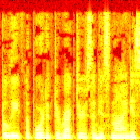

In [33]:
from IPython.display import Image

Image(filename = spectrograms[3])

In [34]:
# We use pandas data frames, becuase it makes it easy for us to create a train/test dataset
import pandas as pd

df = pd.DataFrame({"spectrogram": spectrograms})
df["label"] = df.spectrogram.str.extract("sample-\\d+-(\\w+)\\.png", expand=False).apply(lambda x: voices.index(x))
df["voice"] = df.spectrogram.str.extract('sample-\\d+-(\\w+)\\.png', expand=False)

In [35]:
df

,spectrogram,label,voice
0,data/spectrograms/sample-00000-Matthew.png,6,Matthew
1,data/spectrograms/sample-00001-Kendra.png,4,Kendra
2,data/spectrograms/sample-00002-Ivy.png,0,Ivy
3,data/spectrograms/sample-00003-Joanna.png,1,Joanna
4,data/spectrograms/sample-00004-Kimberly.png,5,Kimberly
...,...,...,...
1995,data/spectrograms/sample-01995-Ivy.png,0,Ivy
1996,data/spectrograms/sample-01996-Salli.png,7,Salli
1997,data/spectrograms/sample-01997-Kendra.png,4,Kendra
1998,data/spectrograms/sample-01998-Kendra.png,4,Kendra


In [36]:
# create a stratified split
train = df.groupby("voice").apply(lambda x: x.sample(frac=.8)).reset_index(0, drop=True)
validation = df.loc[np.logical_not(df.index.isin(train.index)), :]

In [37]:
train.groupby("voice")["label"].count().reset_index()

,voice,label
0,Ivy,184
1,Joanna,187
2,Joey,204
3,Justin,189
4,Kendra,228
5,Kimberly,227
6,Matthew,194
7,Salli,186


In [38]:
validation.groupby("voice")["label"].count().reset_index()

,voice,label
0,Ivy,46
1,Joanna,47
2,Joey,51
3,Justin,47
4,Kendra,57
5,Kimberly,57
6,Matthew,49
7,Salli,47


In [39]:
# The computer vision library for Python allows us to read images as numerical array
import cv2
import mxnet as mx

# MXNet understands numbers, so our spectrograms need to become just that. Labels as well.
def transform(row):
    img = cv2.imread(row["spectrogram"])
    img = mx.nd.array(img)
    img = img.astype(np.float32)
    # MXNet CN require a specific order of an image dimensions(colors, x, y) instead of (x, y, colors)
    img = mx.nd.transpose(img, (2, 0, 1))
    # Normalize data between 0 and 1
    img = img / 255
    label = np.float32(row["label"])
    return img, label

In [40]:
train_nd = [transform(row) for _, row in train.iterrows()]
validation_nd = [transform(row) for _, row in validation.iterrows()]

In [41]:
train_nd[0]

(
 [[[0.         0.         0.         ... 0.         0.         0.        ]
   [0.         0.         0.         ... 0.         0.         0.        ]
   [0.         0.         0.         ... 0.         0.         0.        ]
   ...
   [0.         0.         0.08627451 ... 0.25490198 0.         0.22745098]
   [0.         0.         0.00784314 ... 0.22745098 0.         0.05490196]
   [0.         0.         0.         ... 0.         0.         0.08627451]]
 
  [[0.         0.         0.         ... 0.         0.         0.        ]
   [0.         0.         0.         ... 0.         0.         0.        ]
   [0.         0.         0.         ... 0.         0.         0.        ]
   ...
   [0.7882353  0.78039217 1.         ... 1.         0.7882353  1.        ]
   [0.9137255  0.8509804  1.         ... 1.         0.7058824  1.        ]
   [0.94509804 0.8        0.9647059  ... 0.88235295 0.8        1.        ]]
 
  [[0.5647059  0.70980394 0.76862746 ... 0.59607846 0.78039217 0.8627451 ]
   

In [42]:
batch_size = 32
epochs = 10

In [43]:
from mxnet.gluon.data import DataLoader

train_data = DataLoader(train_nd, batch_size, shuffle=True)
validation_data = DataLoader(validation_nd, batch_size, shuffle=True)

In [44]:
from mxnet.gluon.nn import Sequential, Conv2D, MaxPool2D, Dropout, Flatten, Dense

net = Sequential()
with net.name_scope():
    net.add(Conv2D(channels=32, kernel_size=(3, 3), padding=0, activation="relu"))
    net.add(Conv2D(channels=32, kernel_size=(3, 3), padding=0, activation="relu"))
    net.add(MaxPool2D(pool_size=(2, 2))) # Reduces overfitting, reduces spatial input, reduces computation
    net.add(Dropout(.25)) # Reduces overfitting
    net.add(Flatten())
    net.add(Dense(8))

In [45]:
from mxnet.initializer import Xavier

# Also known as Glorot
net.initialize(Xavier(magnitude=2.24), ctx=mx.cpu())

In [46]:
from mxnet.gluon import Trainer

trainer = Trainer(net.collect_params(), optimizer="adam")

In [47]:
from mxnet.gluon.contrib import estimator
from mxnet.metric import Accuracy
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss

est = estimator.Estimator(net=net, loss=SoftmaxCrossEntropyLoss(), metrics=Accuracy(), trainer=trainer)
est.fit(train_data=train_data, epochs=epochs, val_data=validation_data)

/home/docker/.local/lib/python3.7/site-packages/mxnet/gluon/contrib/estimator/estimator.py:357: UserWarning: You are training with the following default event handlers: MetricHandler, ValidationHandler, LoggingHandler. They use loss and metrics from estimator.prepare_loss_and_metrics(). Please use the same set of metrics for all your other handlers.
  warnings.warn(msg)
Training begin: using optimizer Adam with current learning rate 0.0010 
Train for 10 epochs.
[Epoch 0] Begin, current learning rate: 0.0010
[Epoch 0] Finished in 113.297s, train accuracy: 0.2033, train softmaxcrossentropyloss: 2.4998, validation accuracy: 0.4638, validation softmaxcrossentropyloss: 1.6445
[Epoch 1] Begin, current learning rate: 0.0010
[Epoch 1] Finished in 114.435s, train accuracy: 0.7230, train softmaxcrossentropyloss: 0.8582, validation accuracy: 0.9377, validation softmaxcrossentropyloss: 0.3096
[Epoch 2] Begin, current learning rate: 0.0010
[Epoch 2] Finished in 112.215s, train accuracy: 0.9450, tra

In [48]:
Audio(filename="Kimberly recites some shameless self promotion ad.mp3", autoplay=True)

In [49]:
%%sh
# Copy the ready-made sample into the mp3 folder becuase that's where the processing function expects it to be
cp Kimberly\ recites\ some\ shameless\ self\ promotion\ ad.mp3 data/mp3/

In [50]:
%%sh
ls -al data/mp3 | head -6

total 93492
drwxr-xr-x 2003 docker docker  64096 Dec  3 20:09 .
drwxr-xr-x    6 docker docker    192 Dec  3 19:41 ..
-rw-r--r--    1 docker docker  49573 Dec  3 20:09 Kimberly recites some shameless self promotion ad.mp3
-rw-r--r--    1 docker docker  27787 Dec  3 19:16 sample-00000-Matthew.mp3
-rw-r--r--    1 docker docker  98004 Dec  3 19:16 sample-00001-Kendra.mp3


In [51]:
process_mp3(None, "Kimberly recites some shameless self promotion ad.mp3")

In [52]:
%%sh
ls -al data/wav | head -6

total 175492
drwxr-xr-x 2003 docker docker 64096 Dec  3 20:09 .
drwxr-xr-x    6 docker docker   192 Dec  3 19:41 ..
-rw-r--r--    1 docker docker 88244 Dec  3 20:09 Kimberly recites some shameless self promotion ad.wav
-rw-r--r--    1 docker docker 88244 Dec  3 19:18 sample-00000-Matthew.wav
-rw-r--r--    1 docker docker 88244 Dec  3 19:18 sample-00001-Kendra.wav


In [53]:
graph_spectrogram("Kimberly recites some shameless self promotion ad.wav")

In [54]:
%%sh
ls -al data/spectrograms | head -6

total 55960
drwxr-xr-x 2003 docker docker 64096 Dec  3 20:09 .
drwxr-xr-x    6 docker docker   192 Dec  3 19:41 ..
-rw-r--r--    1 docker docker 27547 Dec  3 20:09 Kimberly recites some shameless self promotion ad.png
-rw-r--r--    1 docker docker 26883 Dec  3 19:41 sample-00000-Matthew.png
-rw-r--r--    1 docker docker 27457 Dec  3 19:41 sample-00001-Kendra.png


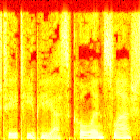

In [55]:
Image(filename = "data/spectrograms/Kimberly recites some shameless self promotion ad.png")

In [56]:
row = {
    "spectrogram": "data/spectrograms/Kimberly recites some shameless self promotion ad.png",
    "label": -1
}

In [57]:
img_as_ndarray, _ = transform(row)

In [58]:
img_as_ndarray.shape

(3, 140, 140)

In [59]:
one_ndarray_batch = mx.ndarray.expand_dims(img_as_ndarray, axis=0)

In [60]:
one_ndarray_batch


[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.02745098 0.         0.         ... 0.         0.
    0.19215687]
   [0.03921569 0.03921569 0.09019608 ... 0.00784314 0.12941177
    0.22352941]
   [0.07843138 0.05882353 0.12941177 ... 0.07058824 0.10196079
    0.25490198]
   ...
   [0.87058824 0.93333334 0.8627451  ... 0.8392157  0.6862745
    0.8509804 ]
   [0.8117647  0.9019608  0.9529412  ... 0.89411765 0.69803923
    0.88235295]
   [0.47058824 0.7882353  0.64705884 ... 0.76862746 0.52156866
    0.64705884]]

  [[1.         0.8509804  0.7921569  ... 0.9882353  0.94509804
    1.        ]
   [1.     

In [61]:
raw_prediction = net(one_ndarray_batch)

In [62]:
raw_prediction


[[-26.737743   -9.831573  -20.880621  -16.928469  -11.083193   -4.6131773
  -24.920668   -7.349285 ]]
<NDArray 1x8 @cpu(0)>

In [63]:
idx = mx.nd.argmax(raw_prediction, axis=1) \
    .asnumpy() \
    .astype(np.int) \
    .ravel()[0]

In [64]:
idx

5

In [65]:
voices[idx]

'Kimberly'

In [66]:
test_phrase = input("What phrase to pronounce?")
test_voice = input("Ivy, Joanna, Joey, Justin, Kendra, Kimberly, Matthew or Salli?")

What phrase to pronounce?Today is raining outside so I think we should use the umbrella.
Ivy, Joanna, Joey, Justin, Kendra, Kimberly, Matthew or Salli?Joanna


In [67]:
session = boto3.session.Session()
client = session.client("polly", region_name="us-east-1")
test_response = client.synthesize_speech(
    OutputFormat="mp3",
    Text=test_phrase,
    TextType="text",
    VoiceId=test_voice
)
with closing(test_response["AudioStream"]) as stream:
    # Write the stream to a bytes buffer in memory
    with io.BytesIO() as buffer:
        # If we fail, for whatever reason (Eg: AWS is throttling us), we skip the file
        try:
            buffer.write(stream.read())
            buffer.seek(0)
            # Finally write the mp3 to disk
            with open("test.mp3", "wb") as out:
                out.write(buffer.read())
        except _:
            pass

In [68]:
Audio(filename="test.mp3", autoplay=True)

In [69]:
%%sh
cp test.mp3 data/mp3/

In [70]:
process_mp3(None, "test.mp3")
graph_spectrogram("test.wav")
test_row = {
    "spectrogram": "data/spectrograms/test.png",
    "label": -1
}
test_img_as_ndarray, _ = transform(test_row)
test_raw_prediction = net(mx.ndarray.expand_dims(test_img_as_ndarray, axis=0))
test_idx = mx.nd.argmax(test_raw_prediction, axis=1) \
    .asnumpy() \
    .astype(np.int) \
    .ravel()[0]
voices[test_idx]

'Joanna'